## 1.- Introduction

 This is the first notebook for predicting the price of the kryptocurrency Chainlink. This is part of a project mainly with academic purposes.
 We will begin by doing some data understanding and then I will try to model
 the behaviour of the price variable. Most of my code is developed following the documentation pages along with the help of Jason Brownlee and his wonderfull Machine Learning Blog which I consider it is the best starting point to Time Series and to most of the ML problems nowadays.

In [113]:
import os
import pandas as pd
import matplotlib.pyplot as plt

os.listdir()
clk = pd.read_csv('LINK-EUR.csv')

clk['date'] = clk['time'].apply(lambda x: x[0:10])
clk['hour'] = clk['time'].apply(lambda x: x[11:19])
clk['aux_hour'] = clk['time'].apply(lambda x: x[11:13])

clk.columns = ['xx', 'timestamp', 'price', 'volume', 'side', 'date', 'hour', 'aux_hour']
clk = clk[['timestamp', 'date', 'hour', 'aux_hour', 'price', 'volume', 'side']]
clk = clk.iloc[14:]

print(clk.shape)
clk.head(3)

(99986, 7)


,timestamp,date,hour,aux_hour,price,volume,side
14,2021-04-24 00:00:07.440,2021-04-24,00:00:07,00,29.19000,60.36,sell
15,2021-04-24 00:00:09.953,2021-04-24,00:00:09,00,29.19000,45.64,sell
16,2021-04-24 00:00:16.813,2021-04-24,00:00:16,00,29.18802,30.70,buy


In [114]:
fd, ld = clk['date'].head(1).values, clk['date'].tail(1).values
print(f"Firs date of data {fd}, and last date {ld}")

Firs date of data ['2021-04-24'], and last date ['2021-05-05']


In [115]:
print(" Total ops by day ---> ", clk.groupby('date').count()['timestamp'].mean())
print(" Total ops by hour -->  ", clk.groupby(['date', 'aux_hour']).count()['timestamp'].mean())

 Total ops by day --->  8332.166666666666
 Total ops by hour -->   363.5854545454545


Let us compute the average price by hour and the standard deviation of price by hour

In [116]:
avgs = clk[['date', 'aux_hour', 'price']].groupby(['date', 'aux_hour']).mean()
avgs.columns = ['avg_price_by_hour']

clk = clk.merge(avgs, how = 'left', on=['date', 'aux_hour'])

stds = clk[['date', 'aux_hour', 'price']].groupby(['date', 'aux_hour']).std()
stds.columns = ['std_price_by_hour']

clk = clk.merge(stds, how = 'left', on=['date', 'aux_hour'])

In [117]:
clk.head(2)

,timestamp,date,hour,aux_hour,price,volume,side,avg_price_by_hour,std_price_by_hour
0,2021-04-24 00:00:07.440,2021-04-24,00:00:07,00,29.19,60.36,sell,28.237243,0.434915
1,2021-04-24 00:00:09.953,2021-04-24,00:00:09,00,29.19,45.64,sell,28.237243,0.434915


Let us check the hours that has the most volatility:

In [118]:
clk.sort_values('std_price_by_hour', ascending = False)['aux_hour'].unique()

array(['00', '17', '23', '18', '15', '14', '21', '16', '05', '07', '20',
       '12', '04', '03', '09', '22', '01', '02', '11', '10', '08', '13',
       '19', '06'], dtype=object)

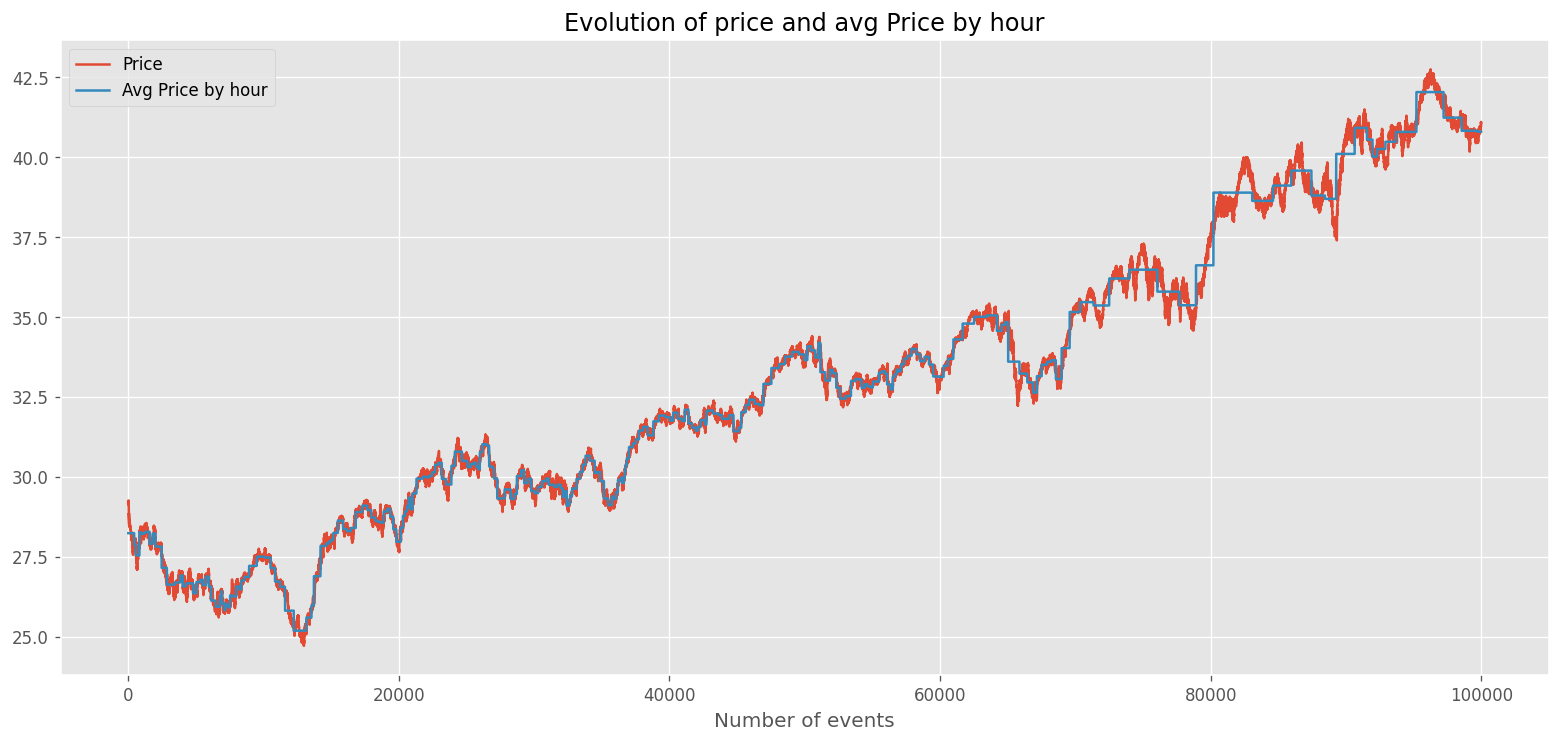

In [119]:
plt.figure(figsize=(16,7))
plt.xlabel('Number of events')

ax1 = clk['price'].plot(label='Price')
ax2 = clk['avg_price_by_hour'].plot(label = 'Avg Price by hour')

plt.title('Evolution of price and avg Price by hour')
plt.legend()
plt.show()

In [120]:
print(" Hours with the higher number of movements ")
clk.loc[clk['std_price_by_hour'] > 0.3, 'aux_hour'].unique()

 Hours with the higher number of movements 


array(['00', '15', '20', '16', '03', '04', '22', '02', '09', '12', '14',
       '17', '18', '21', '23', '01', '05', '07'], dtype=object)

Let us plot the variable distribution

Text(0.5, 1.0, 'CLK Price Distribution')

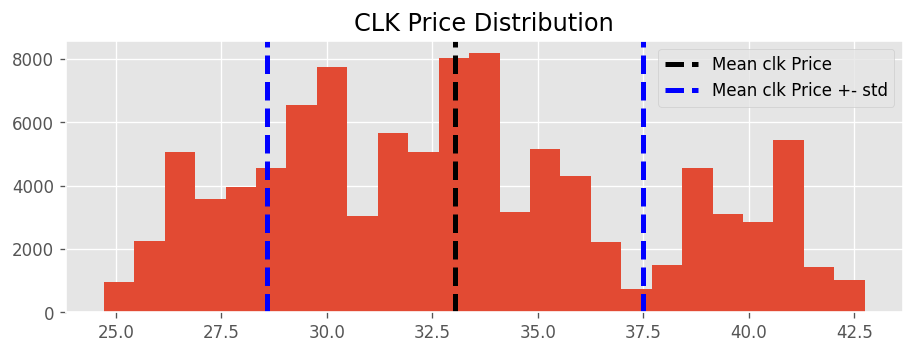

In [121]:
clk['price'].hist(bins = 25)
plt.axvline(clk['price'].mean(), color='k', linestyle='dashed', linewidth=3)
plt.axvline(clk['price'].mean() + clk['price'].std(), color='b', linestyle='dashed', linewidth=3)
plt.axvline(clk['price'].mean() - clk['price'].std(), color='b', linestyle='dashed', linewidth=3)
plt.legend(['Mean clk Price', 'Mean clk Price +- std'])
plt.title('CLK Price Distribution')

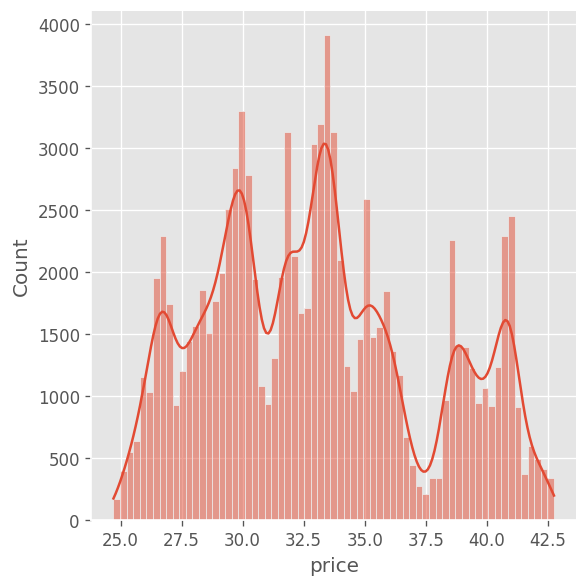

In [122]:
import seaborn as sns

sns.displot(data=clk['price'], kde=True)

In [123]:
clk.corr()

,price,volume,avg_price_by_hour,std_price_by_hour
price,1.000000,-0.019137,0.997805,0.533855
volume,-0.019137,1.000000,-0.017977,0.001408
avg_price_by_hour,0.997805,-0.017977,1.000000,0.535030
std_price_by_hour,0.533855,0.001408,0.535030,1.000000


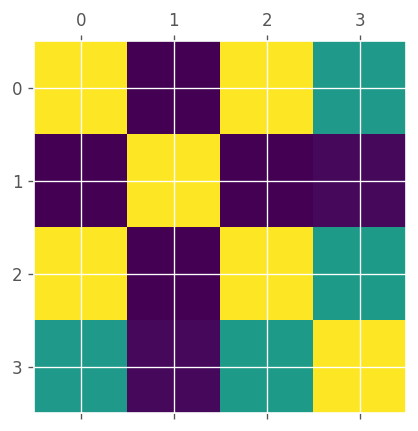

In [124]:
plt.matshow(clk.corr())
plt.show()

In [125]:
clk.head()

,timestamp,date,hour,aux_hour,price,volume,side,avg_price_by_hour,std_price_by_hour
0,2021-04-24 00:00:07.440,2021-04-24,00:00:07,00,29.19000,60.36,sell,28.237243,0.434915
1,2021-04-24 00:00:09.953,2021-04-24,00:00:09,00,29.19000,45.64,sell,28.237243,0.434915
2,2021-04-24 00:00:16.813,2021-04-24,00:00:16,00,29.18802,30.70,buy,28.237243,0.434915
3,2021-04-24 00:00:20.042,2021-04-24,00:00:20,00,29.20000,20.00,sell,28.237243,0.434915
4,2021-04-24 00:00:20.386,2021-04-24,00:00:20,00,29.22945,0.23,sell,28.237243,0.434915


In [126]:
clk.to_csv('processed_data.csv', sep = '|', index = False, header= True)

## 2.- Arima Models

They are known to be computationally expensive. Just because we have plotted the series and we could not observe a clear seasonal trend we will not speak about seasonality or **sarimax models** for the moment.
They can be briefly explained as:

    - AR: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.
    - I: Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.
    - MA: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

Each of these components are explicitly specified in the model as a parameter. A standard notation is used of ARIMA(p,d,q) where the parameters are substituted with integer values to quickly indicate the specific ARIMA model being used.

The parameters of the ARIMA model are defined as follows:
    - p: The number of lag observations included in the model, also called the lag order.
    - d: The number of times that the raw observations are differenced, also called the degree of differencing.
    - q: The size of the moving average window, also called the order of moving average.


In [127]:
price = clk['price'].values
price.shape

(99986,)

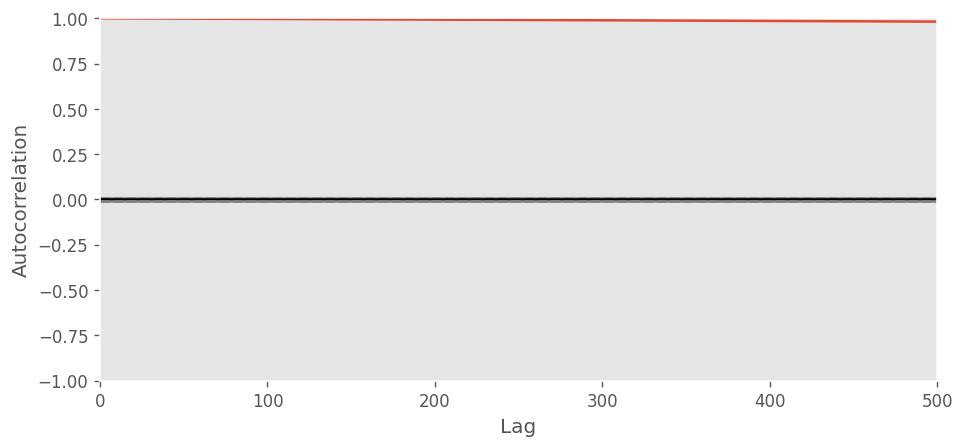

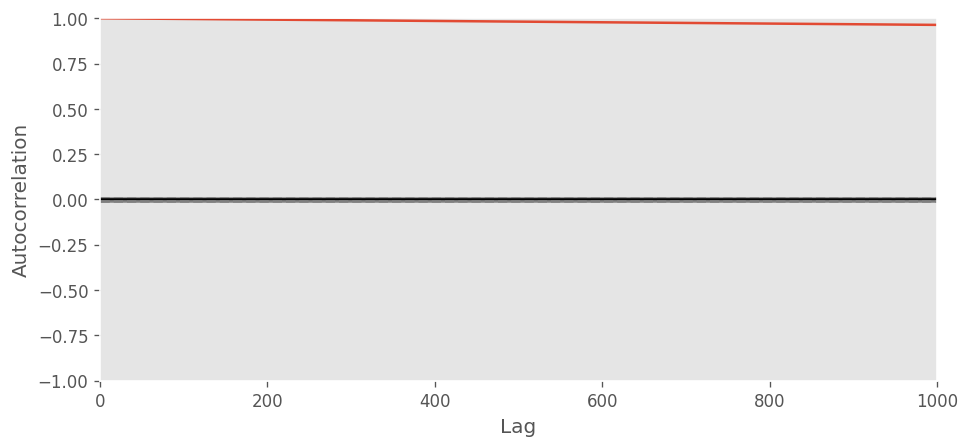

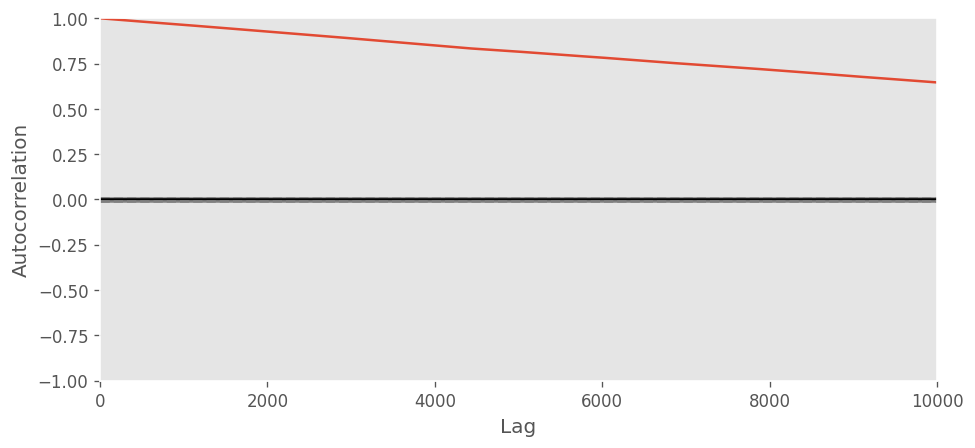

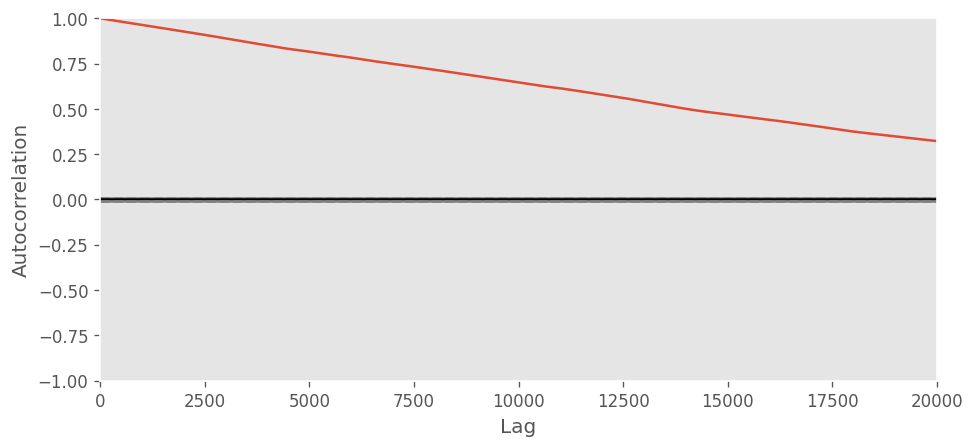

In [128]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [9, 4]

from pandas.plotting import autocorrelation_plot
for i in [500, 1000, 10000, 20000]:
    autocorrelation_plot(price).set_xlim([0, i])
    plt.show()

We can see the autocorrelation follows a rather descending linear trend so the higher correlations are within the first 1000 observations.
This makes us hard to choose the AR parameter because there is not a clear winner. Let us assume AR equals to 1.

From now on, in order to make faster computations we will subsample the series. I have performed several tests in order to check if the subsampled serie is representative of the 'father' serie like the Kolmogorov-Smirnov test but results are difficult to interpret. 

In [129]:
ar1 = price[70000:]
ar1.shape

(29986,)

In [130]:
from scipy.stats import ks_2samp

ks_2samp(ar1, price), ks_2samp(price, price)

(Ks_2sampResult(statistic=0.6704739857470527, pvalue=0.0),
 Ks_2sampResult(statistic=-0.0, pvalue=1.0))

In [131]:
ar1.mean(), ar1.std(), price.mean(), price.std()

(38.63782578003068, 2.193083769396283, 33.04378635468965, 4.453526492521506)

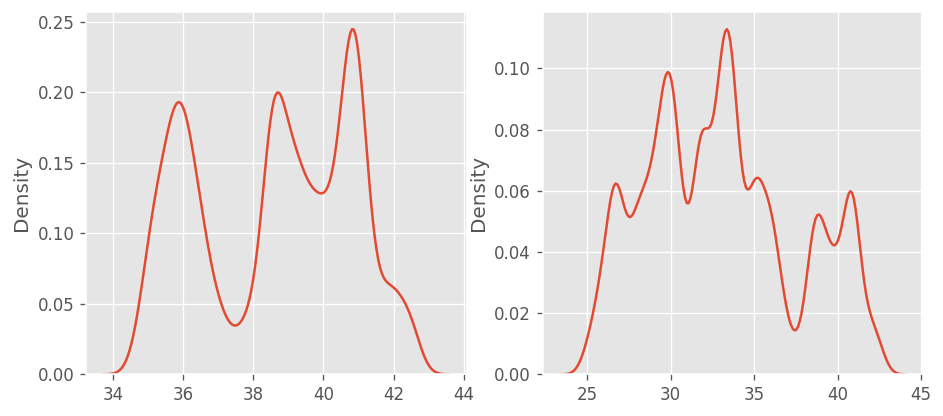

In [132]:
f, axes = plt.subplots(1, 2)
sns.kdeplot(ar1, ax=axes[0])
sns.kdeplot(price, ax=axes[1])

We can see statistical moments are in some way similar and both distributions are bimodal. Since probability of correlation is way higher with last values than with older ones I would consider the mini serie as representative.

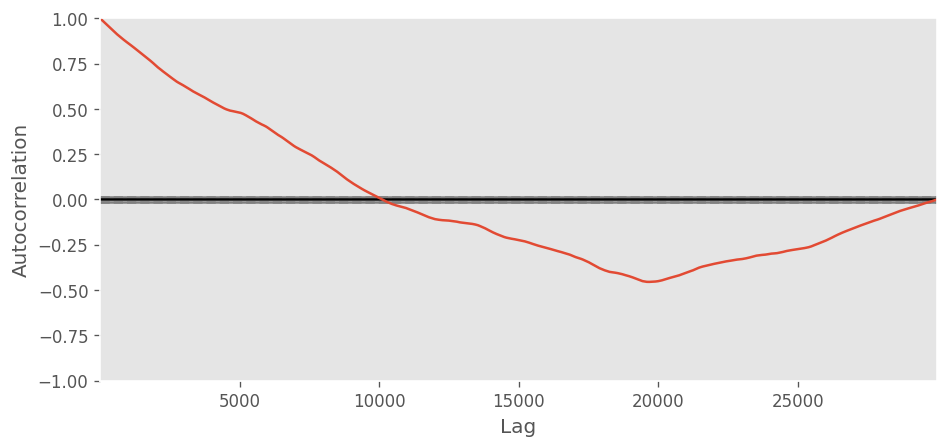

In [133]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(ar1)
plt.show()

Let us find the d parameter. To do so, we need to differentiate until we reach the stationary state. We can see that just differencing once we obtain a rather flat curve. So $d=1$

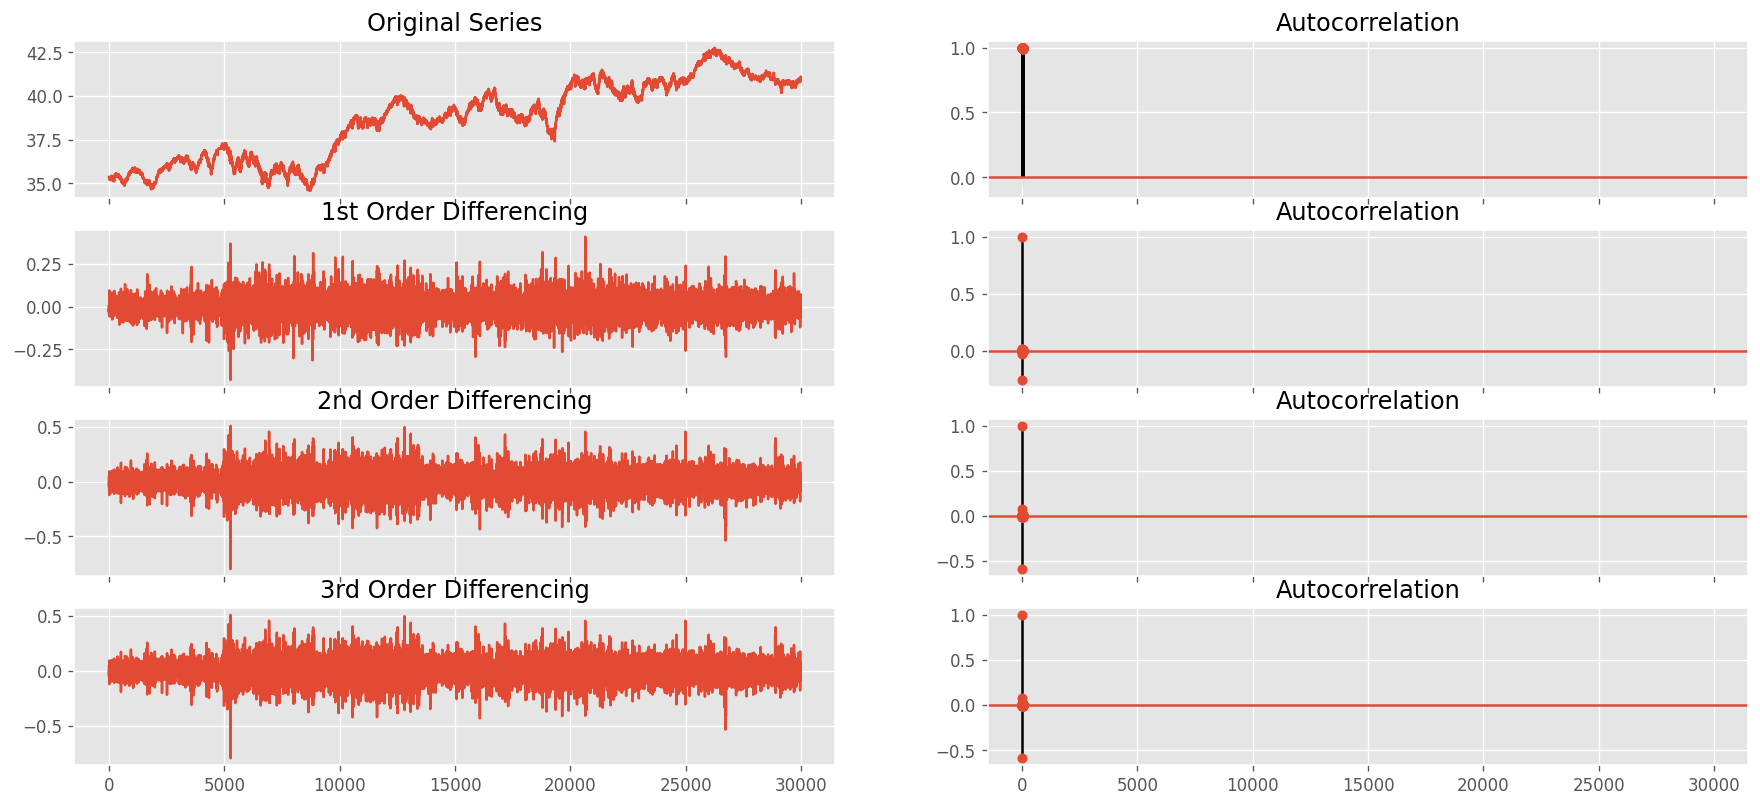

In [134]:
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams['figure.figsize'] = [18, 8]



diff1 = np.diff(ar1)
diff2 = np.diff(diff1)
diff3 = np.diff(diff2)

# Original Series
fig, axes = plt.subplots(4, 2, sharex=True)
axes[0, 0].plot(ar1); axes[0, 0].set_title('Original Series')
plot_acf(ar1, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(diff1); axes[1, 0].set_title('1st Order Differencing')
plot_acf(diff1, ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(diff2); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(diff2, ax=axes[2, 1])

axes[3, 0].plot(diff2); axes[3, 0].set_title('3rd Order Differencing')
plot_acf(diff2, ax=axes[3, 1])


plt.show()

The next step is to identify if the model needs any AR terms. You can find out the required number of AR terms by inspecting the Partial Autocorrelation (PACF) plot.

But what is PACF?

Partial autocorrelation can be imagined as the correlation between the series and its lag, after excluding the contributions from the intermediate lags. So, PACF sort of conveys the pure correlation between a lag and the series. That way, you will know if that lag is needed in the AR term or not.

Lagg 1 is very significant. Then $p=1$

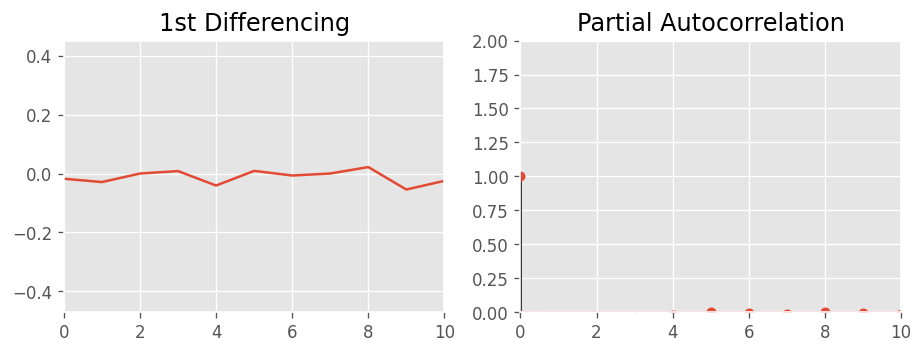

In [135]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(diff1); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,2), xlim = (0, 10))
plot_pacf(diff1, ax=axes[1])

plt.show()

Just like how we looked at the PACF plot for the number of AR terms, you can look at the ACF plot for the number of MA terms. An MA term is technically, the error of the lagged forecast.

The ACF tells how many MA terms are required to remove any autocorrelation in the stationarized series.

Let’s see the autocorrelation plot of the differenced series.

We can see that there is no significant term. We will fix $q=0$

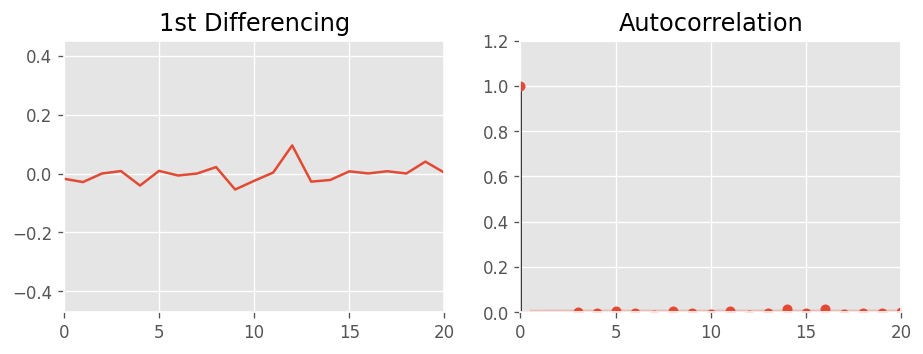

In [136]:
fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(diff1); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2), xlim = (0,20))
plot_acf(diff1, ax=axes[1])

plt.show()

Considering the long time it takes to fit an Arima model, we will just train 1 model.

In [137]:
ar1.shape

(29986,)

In [138]:
train, test =  ar1[:25000],  ar1[25000:]
train.shape, test.shape

((25000,), (4986,))

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                24999
Model:                 ARIMA(1, 1, 0)   Log Likelihood               41889.002
Method:                       css-mle   S.D. of innovations              0.045
Date:                Thu, 19 Aug 2021   AIC                         -83772.003
Time:                        12:52:07   BIC                         -83747.623
Sample:                             1   HQIC                        -83764.112
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.000      0.926      0.355      -0.000       0.001
ar.L1.D.y     -0.2504      0.006    -40.901      0.000      -0.262      -0.238
                                    Roots           

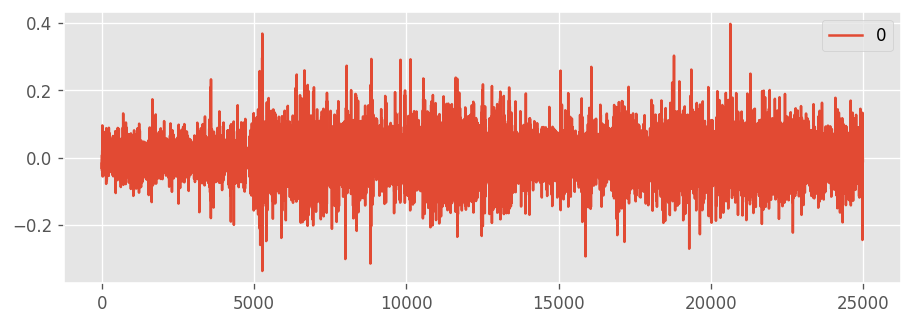

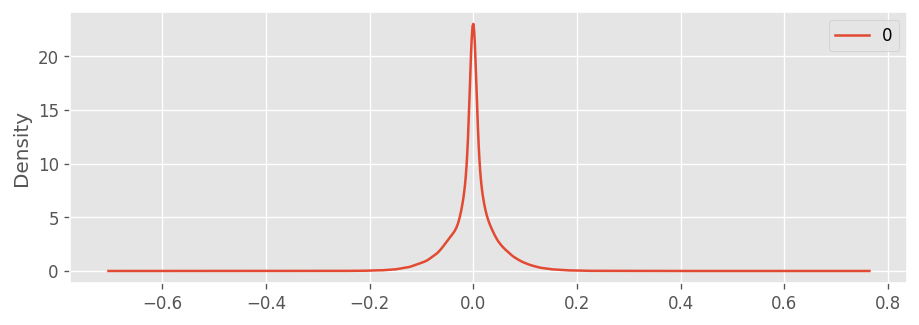

                  0
count  2.499900e+04
mean  -1.740250e-07
std    4.529554e-02
min   -3.367955e-01
25%   -1.572729e-02
50%   -2.651416e-04
75%    1.588147e-02
max    3.974473e-01


In [139]:
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot
from pandas import DataFrame

pdq = (1,1,0)

model = ARIMA(train, order = pdq)
model_fit = model.fit(disp = 0)
print(model_fit.summary())
# plot residual errors
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

The residuals do not follow a trend and seem to be rather constant variance and mean, and the distribution is kind of Gaussian although a bit sharp. Let us check how it performs over the test set. 

In [140]:
import numpy as np

periods_to_fore = 30
real = test[:periods_to_fore]
fforecasted = model_fit.forecast(periods_to_fore)[0]
l_errors = list()

for index, value in enumerate (model_fit.forecast(periods_to_fore)[0]):
    error = abs(real[index] - value)
    l_errors.append(error)
    
print(f" Mean of absolute errors over {periods_to_fore} ---> {np.array(l_errors).mean()}")

 Mean of absolute errors over 30 ---> 0.0970690350110253


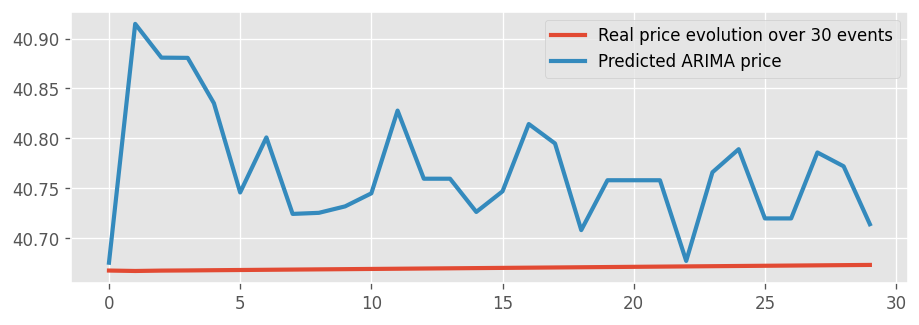

In [141]:
plt.plot(model_fit.forecast(periods_to_fore)[0], linewidth  = 2.5)
# plt.plot(preds, linewidth  = 2.5)
plt.plot(real, linewidth  = 2.5)
plt.legend(['Real price evolution over 30 events', 'Predicted ARIMA price'])
plt.show()

In [142]:
model_fit.forecast(1)

(array([40.66750456]),
 array([0.04529462]),
 array([[40.57872873, 40.7562804 ]]))

In [143]:
model_fit.forecast(periods_to_fore)[0]

array([40.66750456, 40.66707234, 40.66744573, 40.66761736, 40.66783952,
       40.66804902, 40.66826169, 40.66847357, 40.66868565, 40.66889768,
       40.66910972, 40.66932176, 40.6695338 , 40.66974584, 40.66995788,
       40.67016992, 40.67038196, 40.67059399, 40.67080603, 40.67101807,
       40.67123011, 40.67144215, 40.67165419, 40.67186623, 40.67207827,
       40.6722903 , 40.67250234, 40.67271438, 40.67292642, 40.67313846])

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                24999
Model:                 ARIMA(0, 1, 1)   Log Likelihood               42015.881
Method:                       css-mle   S.D. of innovations              0.045
Date:                Thu, 19 Aug 2021   AIC                         -84025.761
Time:                        12:52:09   BIC                         -84001.382
Sample:                             1   HQIC                        -84017.870
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.000      1.046      0.295      -0.000       0.001
ma.L1.D.y     -0.2884      0.006    -46.037      0.000      -0.301      -0.276
                                    Roots           

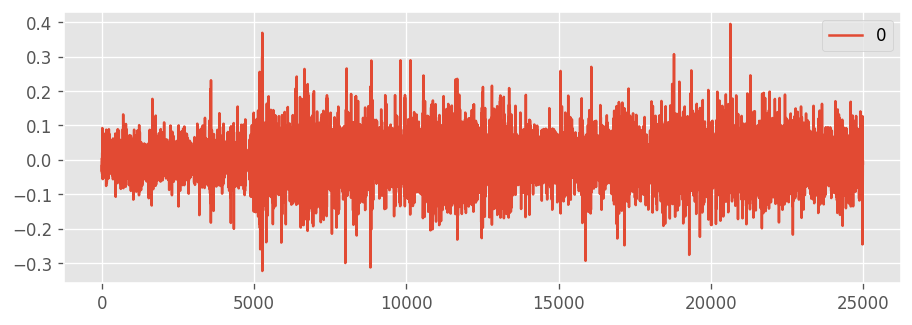

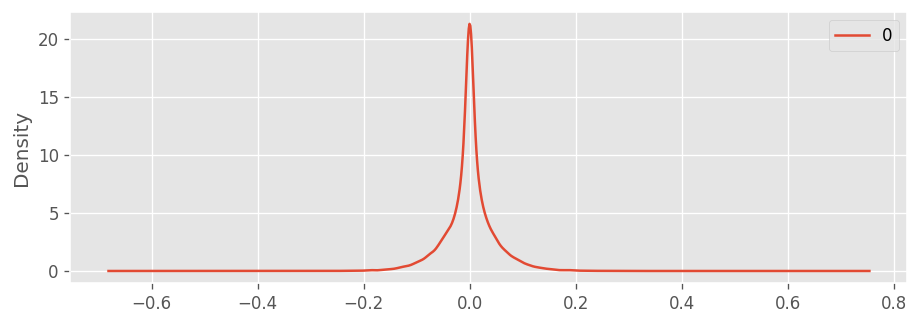

                  0
count  2.499900e+04
mean  -3.949611e-07
std    4.506622e-02
min   -3.226665e-01
25%   -1.643757e-02
50%   -2.954985e-04
75%    1.650674e-02
max    3.950999e-01
 Mean of absolute errors over 30 ---> 0.09607943999319891


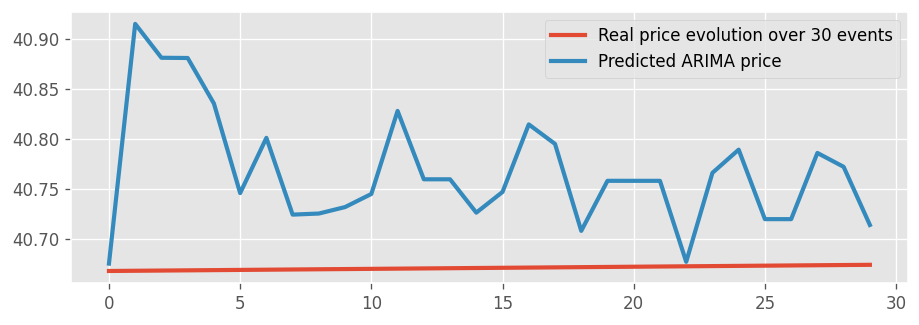

In [144]:
pdq = (0,1,1)

model = ARIMA(train, order = pdq)
model_fit = model.fit(disp = 0)
print(model_fit.summary())
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

periods_to_fore = 30
real = test[:periods_to_fore]
fforecasted = model_fit.forecast(periods_to_fore)[0]
l_errors = list()

for index, value in enumerate (model_fit.forecast(periods_to_fore)[0]):
    error = abs(real[index] - value)
    l_errors.append(error)
    
print(f" Mean of absolute errors over {periods_to_fore} ---> {np.array(l_errors).mean()}")

plt.plot(model_fit.forecast(periods_to_fore)[0], linewidth  = 2.5)
# plt.plot(preds, linewidth  = 2.5)
plt.plot(real, linewidth  = 2.5)
plt.legend(['Real price evolution over 30 events', 'Predicted ARIMA price'])
plt.show()

We can see we are obtaining horrible results. Curves we are predicting are c horizontal and flat. Since the number of fwd points to be forecasted is important, we could try just to predict the next time step and then retrain the model with the nsteps + 1 but this give us bad results once again because the model is training with almost same points.

I have tested several combinations of pdq parameters and none of them are working properly. The explanation for this might be a seasonal component not aditive nor multiplicative that I am not considering, but since there is not a fixed number of events per day/ per period of time we can not set the periodicity. This is the reason why I will not test SARIMAX model neither.
I am not saying that these models can not be fitted an work well on my dataset but I do not know how to make it right.

## 2.2.- Prophet
For this part I will test the prophet library developed by Facebook which is said to perform well on these kinds of problems and improves the performance of Arima models

In [145]:
from prophet import Prophet

In [146]:
df = clk[['date', 'price']]
df.columns = ['ds', 'y']
# df = df.set_index('ds')
m = Prophet()
m.fit(df)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [147]:
future = list()
events = 10
from pandas import to_datetime

for i in range(6, 6 + events):
	date = '2021-05-%02d' % i
	future.append([date])
future = DataFrame(future)
future.columns = ['ds']
future['ds']= to_datetime(future['ds'])

In [148]:
df.tail(2)

,ds,y
99984,2021-05-05,41.10125
99985,2021-05-05,41.06351


In [149]:
future.head(2)

,ds
0,2021-05-06
1,2021-05-07


In [150]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2021-05-06,45.252916,43.428689,47.028335
1,2021-05-07,49.587245,46.972613,52.383691
2,2021-05-08,53.921573,49.766707,58.499812
3,2021-05-09,58.255902,51.861641,64.918637
4,2021-05-10,62.590231,53.630750,71.612012
5,2021-05-11,66.924560,55.623758,79.280126
6,2021-05-12,71.258889,56.698572,86.991921
7,2021-05-13,75.593217,57.730039,94.474181
8,2021-05-14,79.927546,58.312116,102.825207
9,2021-05-15,84.261875,58.378961,110.408953


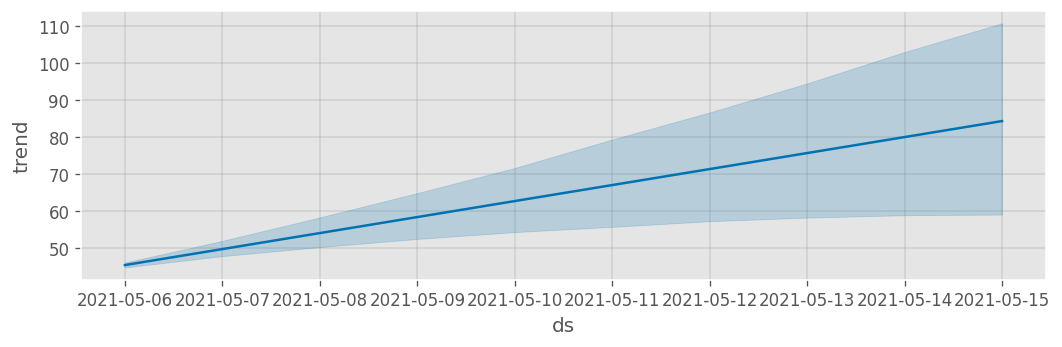

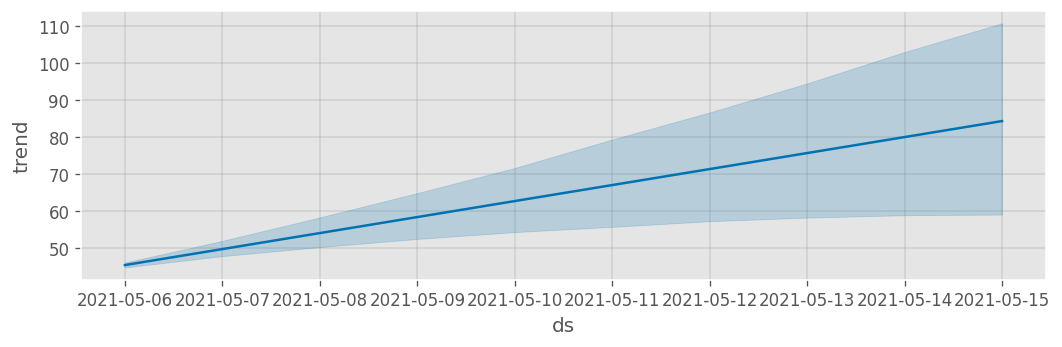

In [151]:
m.plot_components(forecast)

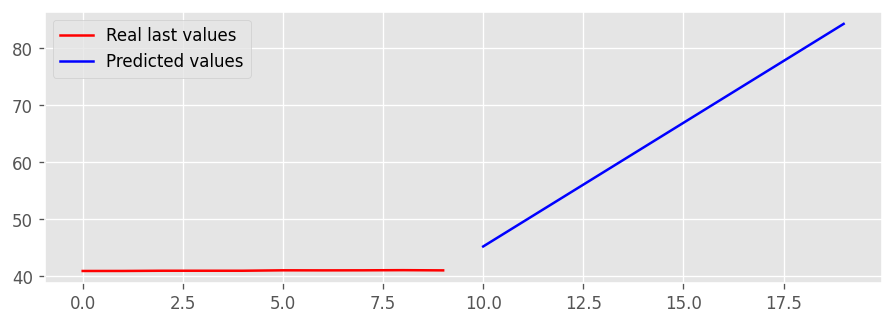

In [152]:
p1 = df['y'].tail(10).values.tolist()
p2 = forecast['yhat'].values.tolist()

plt.plot(range(0,10), p1, 'r') 
plt.plot(range(10,20), p2, 'b')  
plt.legend(['Real last values', 'Predicted values'])
plt.show()

## 3.- Results

As we can see Prophet is returning a flat line as predictions that grows way faster than what we could expect as the true behaviour of the series. It is not capturing the trend properly and the results are pretty akward.
This might be because I am not making a good use of the library, not because of the library itself. 

So, we can see that neither with Arima models neither with the Prophet library we have captured the trends properly. I hope better luck for DL based models.